In [ ]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8

In [ ]:
# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

In [ ]:
PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986-2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1984-2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    # "biomass_afg": pjoin(
    #     FEATURE_DIR, "biomass/1986_2020_biomass_afg_{}.nc".format(STATE.lower())
    # ),
    # "biomass_pfg": pjoin(
    #     FEATURE_DIR, "biomass/1986_2020_biomass_pfg_{}.nc".format(STATE.lower())
    # ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(1986, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
# BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

In [ ]:
def get_nc_var_name(ds):
    # Find the data variable in a nc xarray.Dataset
    # var_name = list(set(ds.keys()) - set(["crs", "day_bnds"]))[0]
    var_name = list(set(ds.keys()) - set(["crs", "bnds"]))[1]
    return var_name

In [ ]:
def netcdf_to_raster(path, date):
    # This produces a Dataset. We need to grab the DataArray inside that
    # contains the data of interest.
    nc_ds = xr.open_dataset(path, chunks={"day": 1})#, decode_times=False)
    # nc_ds = nc_ds.rio.write_crs("EPSG:5071")  # FOR DAYMET ONLY!!
    # nc_ds = nc_ds.rio.write_crs(
    #     nc_ds.coords["lambert_conformal_conic"].spatial_ref
    # )  # FOR DAYMET ONLY!!
    # nc_ds = nc_ds.rename({"lambert_conformal_conic": "crs"})  # FOR DAYMET ONLY!!
    # nc_ds = nc_ds.drop_vars(["lat", "lon"])  # FOR DAYMET ONLY!!
    # nc_ds = nc_ds.rename_vars({"x": "lon", "y": "lat"})  # FOR DAYMET ONLY!!
    # comment lines below for normal operation
    ds_crs = CRS.from_epsg(5071)
    nc_ds.rio.write_crs(ds_crs)
    nc_ds = nc_ds.rio.write_crs(nc_ds.crs.spatial_ref)
    # print nc_ds dimensions
    print(f"{nc_ds.dims = }")
    # Find variable name
    var_name = get_nc_var_name(nc_ds)
    print(f"var_name: {var_name}")
    # Extract
    var_da = nc_ds[var_name]
    print(f"{var_da = }")
    var_da = var_da.sel(time=date, method="nearest")
    xrs = xr.DataArray(
        var_da.data, dims=("y", "x"), coords=(var_da.lat.data, var_da.lon.data)
    ).expand_dims("band")
    xrs["band"] = [1]
    # Set CRS in raster compliant format
    xrs = xrs.rio.write_crs(nc_ds.crs.spatial_ref)
    return Raster(xrs)

In [ ]:
def extract_nc_data(df, gm_name):
    assert df.ig_date.unique().size == 1
    # print(f"{gm_name}: {df.columns = }, {len(df) = }")
    date = df.ig_date.values[0]
    print(f"{gm_name}: starting {date}")
    rs = netcdf_to_raster(PATHS[gm_name], date)
    bounds = gpd.GeoSeries(df.geometry).to_crs(rs.crs).total_bounds
    rs = clipping.clip_box(rs, bounds)
    if type(df) == pd.DataFrame:
        df = gpd.GeoDataFrame(df)
    feat = Vector(df, len(df))
    rdf = (
        zonal.extract_points_eager(feat, rs, skip_validation=True)
        .drop(columns=["band"])
        .rename(columns={"extracted": gm_name})
        .compute()
    )
    df[gm_name].values[:] = rdf[gm_name].values
    # print(f"{gm_name}: finished {date}")
    return df

In [ ]:
def partition_extract_nc(df, key):
    # This func wraps extract_nc_data. It groups the partition in to sub
    # dataframes with the same date and then applies extract_nc_data to
    # each and reassembles the results into an output dataframe.
    parts = []
    for group in df.groupby("ig_date", sort=True):
        _, gdf = group
        parts.append(extract_nc_data(gdf, key))
    return pd.concat(parts)

In [ ]:
def add_columns_to_df(
    df,
    columns,
    part_func,
    out_path,
    col_type=F32,
    col_default=np.nan,
    part_func_args=(),
    tmp_loc=TMP_LOC,
    parallel=True,
):
    print(f"Adding columns: {columns}")
    # Add columns
    expanded_df = df.assign(**{c: col_type.type(col_default) for c in columns})
    with tempfile.TemporaryDirectory(dir=tmp_loc) as working_dir:
        # Save to disk before applying partition function. to_parquet() has a
        # chance of segfaulting and that chance goes WAY up after adding
        # columns and then mapping a function to partitions. Saving to disk
        # before mapping keeps the odds low.
        path = pjoin(working_dir, "expanded")
        expanded_df.to_parquet(path)

        expanded_df = dgpd.read_parquet(path)
        meta = expanded_df._meta.copy()
        for c in columns:
            expanded_df = expanded_df.map_partitions(
                part_func, c, *part_func_args, meta=meta
            )

        if parallel:
            with ProgressBar():
                expanded_df.to_parquet(out_path)
        else:
            # Save parts in serial and then assemble into single dataframe
            with tempfile.TemporaryDirectory(dir=tmp_loc) as part_dir:
                dfs = []
                for i, part in enumerate(expanded_df.partitions):
                    # Save part i
                    part_path = pjoin(part_dir, f"part{i:04}")
                    with ProgressBar():
                        part.compute().to_parquet(part_path)
                    # Save paths for opening with dask_geopandas later. Avoid
                    # opening more dataframes in this loop as doing so will
                    # likely cause a segfault. I have no idea why.
                    dfs.append(part_path)
                dfs = [dgpd.read_parquet(p) for p in dfs]
                # Assemble and save to final output location
                expanded_df = dd.concat(dfs)
                with ProgressBar():
                    expanded_df.to_parquet(out_path)
    return dgpd.read_parquet(out_path)

In [ ]:
# code below used to add new features to the dataset
with ProgressBar():
    df = dgpd.read_parquet(checkpoint_2_path)
df = add_columns_to_df(
    df, DM_KEYS, partition_extract_nc, checkpoint_1_path, parallel=False
)
df = df.repartition(partition_size="100MB").reset_index(drop=True)
print("Repartitioning")
with ProgressBar():
    df.to_parquet(mtbs_df_temp_path)

In [45]:
with ProgressBar():
    df = dgpd.read_parquet(checkpoint_2_path)

In [ ]:
nc_ds = xr.open_dataset(PATHS["aw_mat"], chunks={"day": 1})

In [ ]:
nc_ds.variables

In [ ]:
# a function for comparing and displaying data / coords / info from a collection of xarray datasets
def compare_xr_datasets(datasets, attrs=False, coords=False, info=False):
    for ds in datasets:
        print(f"{ds = }")
        if attrs:
            print(f"{ds.attrs = }")
        if coords:
            print(f"{ds.coords = }")
        if info:
            print(f"{ds.info = }")
        print("-----------------\n\n")

nc_datasets = [xr.open_dataset(PATHS['dm_tmax'], chunks={"day": 1}), xr.open_dataset(PATHS['aw_mat'], chunks={"day": 1})]
compare_xr_datasets(nc_datasets, attrs=True, coords=True, info=True)

In [53]:
nc_ds = xr.open_dataset(PATHS['dm_tmax'], chunks={"day": 1})#, decode_times=False)
nc_ds = nc_ds.rio.write_crs("EPSG:5071")  # FOR DAYMET ONLY!!
nc_ds = nc_ds.rio.write_crs(
    nc_ds.coords["lambert_conformal_conic"].spatial_ref
)  # FOR DAYMET ONLY!!
nc_ds = nc_ds.rename({"lambert_conformal_conic": "crs"})  # FOR DAYMET ONLY!!
nc_ds2 = nc_ds.drop_vars(["lat", "lon"])  # FOR DAYMET ONLY!!
nc_ds2 = nc_ds2.rename_vars({"x": "lon", "y": "lat"})  # FOR DAYMET ONLY!!
nc_ds2

<xarray.Dataset>
Dimensions:    (time: 420, bnds: 2, x: 7814, y: 8075)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-16T12:00:00 ... 2020-12-16
  * lon        (x) float32 -4.56e+06 -4.559e+06 ... 3.252e+06 3.253e+06
  * lat        (y) float32 4.984e+06 4.983e+06 ... -3.089e+06 -3.09e+06
    crs        int64 0
Dimensions without coordinates: bnds, x, y
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    tmax       (time, y, x) float32 dask.array<chunksize=(1, 8, 7814), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 2.0.4 (https://mpimet.m...
    Conventions:       CF-1.6
    source:            Daymet Software Version 4.0
    start_year:        1986
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    history:           Thu Aug 17 14:37:44 2023: cdo -f nc4 -z zip cat daymet...
    CDO:               Climate Data Operators version 2.0.4 (https://mpimet.m...

In [90]:
df.ig_date.value_counts()

ig_date
2012-07-08    3249431
2020-09-08    2797930
2002-07-13    2774376
2014-07-14    2366692
2020-08-16    1148381
               ...   
2017-09-18         99
1999-07-09         85
2007-06-29          4
1987-10-12          4
1987-04-14          3
Name: count, Length: 621, dtype: int64

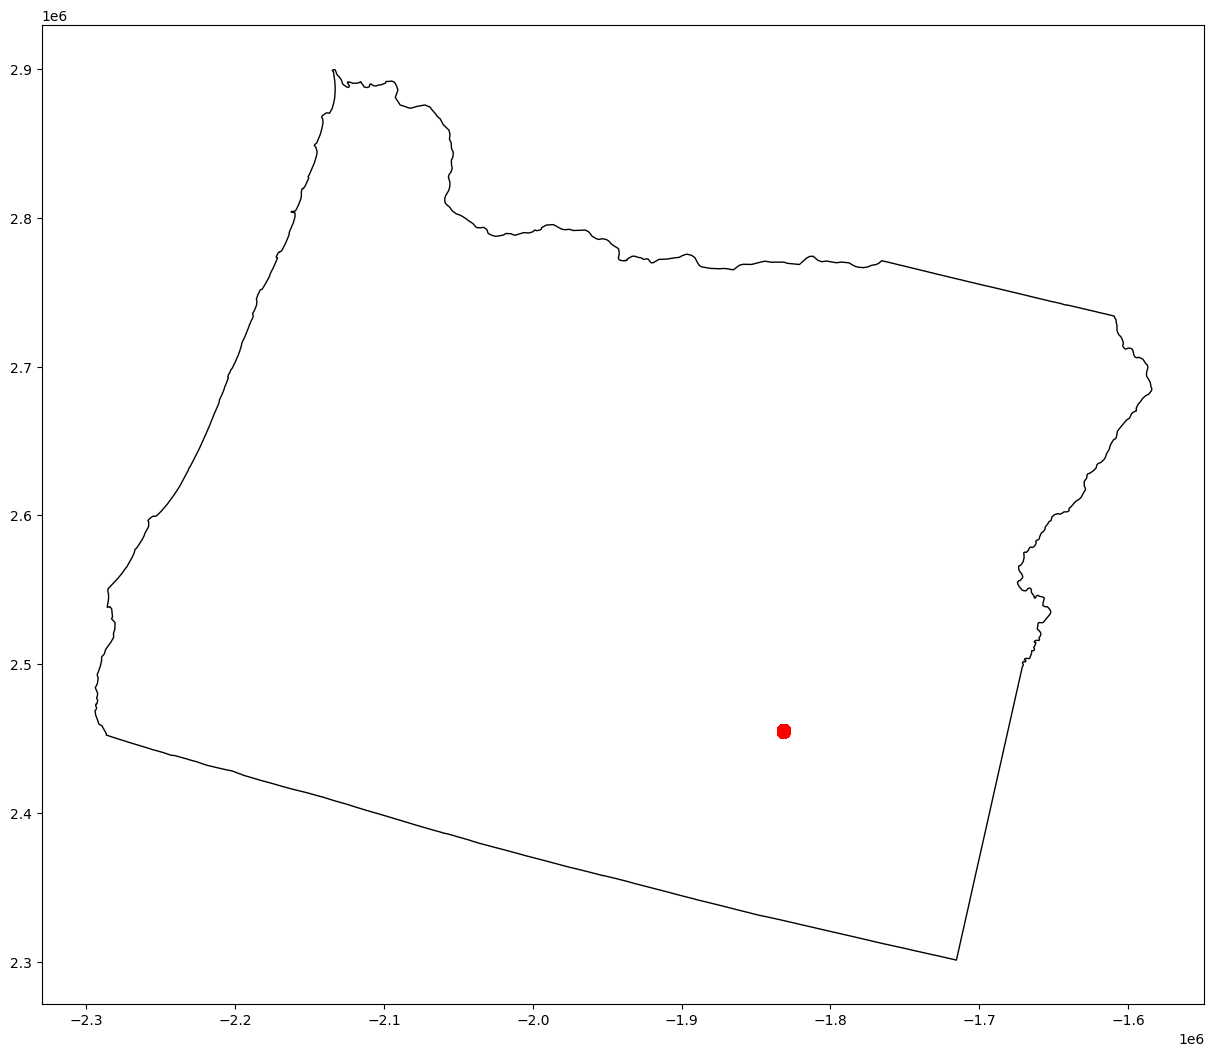

In [99]:
# visually map/draw the fire from df with ig_date = 1986-03-20
import matplotlib.pyplot as plt
# plot with oregon map as background
fig, ax = plt.subplots(figsize=(15,15))
states = gpd.read_file(PATHS['states'])
states = states.to_crs(df.crs)
# limit states to just oregon
states = states[states.STUSPS == 'OR']
states.plot(ax=ax, color='white', edgecolor='black')
df[df.ig_date == '2014-07-14'].plot(ax=ax, color='red')
plt.show()

In [66]:
date = df.ig_date.values[0]
var_name = get_nc_var_name(nc_ds2)
# print(f"var_name: {var_name}")
# Extract
var_da = nc_ds2[var_name]
var_da = var_da.sel(time=date, method="nearest")
print(f"{var_da = }")
xrs = xr.DataArray(
    var_da.data, dims=("y", "x"), coords=(var_da.lat.data, var_da.lon.data)
).expand_dims("band")
xrs["band"] = [1]
# Set CRS in raster compliant format
xrs = xrs.rio.write_crs(nc_ds2.crs.spatial_ref)

var_da = <xarray.DataArray 'tmax' (y: 8075, x: 7814)>
dask.array<getitem, shape=(8075, 7814), dtype=float32, chunksize=(8, 7814), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-09-16
  * lon      (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * lat      (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
    crs      int64 0
Dimensions without coordinates: y, x
Attributes:
    long_name:     monthly average of daily maximum temperature
    units:         degrees C
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: maximum within days time: mean over days
